# Part 1: Texture synthesis

In [1]:
import numpy as np
import math
from skimage import io, util, color, img_as_ubyte
import heapq

In [2]:
### Method 1
def randomPatch(texture, patchSize):
    h, w = texture.shape[:2]
    i = np.random.randint(h - patchSize)
    j = np.random.randint(w - patchSize)
    return texture[i:i+patchSize, j:j+patchSize]

def method1(texture, patchSize):
    texture = util.img_as_float(texture)
    h, w = texture.shape[:2]

    if len(texture.shape) == 2:
        texture = np.stack([texture]*3, axis=-1)

    patchH = math.ceil((5 * h) / patchSize)
    patchW = math.ceil((5 * w) / patchSize)

    output = np.zeros((patchH * patchSize, patchW * patchSize, texture.shape[2]))

    for i in range(patchH):
        for j in range(patchW):
            y = i * patchSize
            x = j * patchSize
            patch = randomPatch(texture, patchSize)
            output[y:y+patchSize, x:x+patchSize] = patch
    return output[:5*h, :5*w]

In [3]:
### Method 2
def ssd(patch, patchSize, overlap, output, x, y):
    return (np.sum((patch[:, :overlap] - output[y:y+patchSize, x:x+overlap])**2) if x > 0 else 0) + \
           (np.sum((patch[:overlap, :] - output[y:y+overlap, x:x+patchSize])**2) if y > 0 else 0) - \
           (np.sum((patch[:overlap, :overlap] - output[y:y+overlap, x:x+overlap])**2) if x > 0 and y > 0 else 0) 

def bestPatch(texture, patchSize, overlap, output, x, y):
    h, w = texture.shape[:2]
    errors = np.array([[ssd(texture[i:i+patchSize, j:j+patchSize], patchSize, overlap, output, x, y) for j in range(w - patchSize)] for i in range(h - patchSize)])
    i, j = np.unravel_index(np.argmin(errors), errors.shape)
    return texture[i:i+patchSize, j:j+patchSize]

def method2(texture, patchSize, overlapSize):
    texture = util.img_as_float(texture)
    h, w = texture.shape[:2]

    patchH = math.ceil((5 * h - patchSize) / (patchSize - overlapSize)) + 1
    patchW = math.ceil((5 * w - patchSize) / (patchSize - overlapSize)) + 1

    if len(texture.shape) == 2:
        texture = np.stack([texture]*3, axis=-1)

    output = np.zeros(((patchH * patchSize) - (patchH - 1) * overlapSize, (patchW * patchSize) - (patchW - 1) * overlapSize, texture.shape[2]))

    for i in range(patchH):
        for j in range(patchW):
            y = i * (patchSize - overlapSize)
            x = j * (patchSize - overlapSize)

            if i == 0 and j == 0:
                patch = randomPatch(texture, patchSize)
            else:
                patch = bestPatch(texture, patchSize, overlapSize, output, x, y)
            output[y:y+patchSize, x:x+patchSize] = patch
    return output[:5*h, :5*w]

In [4]:
### Method 3
def cutPatch(patch, overlapSize, output, x, y):
    def path(errors):
        h, w = errors.shape
        queue = [(error, [i]) for i,error in enumerate(errors[0])]
        heapq.heapify(queue)
        visited = set()
        while queue:
            error, path = heapq.heappop(queue)
            depth = len(path)
            index = path[-1]
            if depth == h:
                return path
            for delta in -1, 0, 1:
                next = index + delta
                if 0 <= next < w:
                    if (depth, next) not in visited:
                        heapq.heappush(queue, (error + errors[depth, next], path + [next]))
                        visited.add((depth, next))

    patch = patch.copy()
    dy, dx = patch.shape[:2]
    cut = np.zeros_like(patch, dtype=bool)
    if x > 0:
        for i, j in enumerate(path(np.sum((patch[:,:overlapSize]-output[y:y+dy,x:x+overlapSize])**2, axis=2))):
            cut[i, :j] = True
    if y > 0:
        for j, i in enumerate(path(np.sum((patch[:overlapSize,:]-output[y:y+overlapSize,x:x+dx])**2, axis=2).T)):
            cut[:i, j] = True

    np.copyto(patch, output[y:y+dy, x:x+dx], where=cut)
    return patch

def method3(texture, patchSize, overlapSize):
    texture = util.img_as_float(texture)
    h, w = texture.shape[:2]

    patchH = math.ceil((5 * h - patchSize) / (patchSize - overlapSize)) + 1
    patchW = math.ceil((5 * w - patchSize) / (patchSize - overlapSize)) + 1

    if len(texture.shape) == 2:
        texture = np.stack([texture]*3, axis=-1)

    output = np.zeros(((patchH * patchSize) - (patchH - 1) * overlapSize, (patchW * patchSize) - (patchW - 1) * overlapSize, texture.shape[2]))

    for i in range(patchH):
        for j in range(patchW):
            y = i * (patchSize - overlapSize)
            x = j * (patchSize - overlapSize)

            if i == 0 and j == 0:
                patch = randomPatch(texture, patchSize)
            else:
                patch = bestPatch(texture, patchSize, overlapSize, output, x, y)
                patch = cutPatch(patch, overlapSize, output, x, y)
            output[y:y+patchSize, x:x+patchSize] = patch
    return output[:5*h, :5*w]

In [5]:
def save_image(output, filename):
    io.imshow(output)
    io.show()
    if len(output.shape) == 3:
        io.imsave(filename, img_as_ubyte(output[:,:,:3]))
    else:
        io.imsave(filename, img_as_ubyte(output))

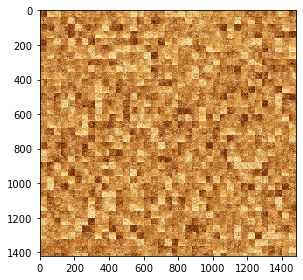

In [20]:
dataDir = 'data/textures/';
outDir = 'results_transfer/';

patchSize = 40
overlapErr = 7

fileName = 'toast.png'
texture = io.imread(dataDir + fileName)

save_image(method1(texture, patchSize), outDir + fileName.split('.')[0] + "_1.jpg")
save_image(method2(texture, patchSize, overlapErr), outDir + fileName.split('.')[0] + "_2.jpg")
save_image(method3(texture, patchSize, overlapErr), outDir + fileName.split('.')[0] + "_3.jpg")

# Part 2: Texture transfer

In [6]:
def corrOver(texture, corrTex, corrTar, patchSize, overlap, output, x, y, alpha=0.1):
    h, w = texture.shape[:2]
    errors = np.zeros((h - patchSize, w - patchSize))
    corrTarP = corrTar[y:y+patchSize, x:x+patchSize]
    di, dj = corrTarP.shape
    for i in range(h - patchSize):
        for j in range(w - patchSize):
            errors[i, j] = alpha * (np.sum(ssd(texture[i:i+di, j:j+dj], patchSize, overlap, output, x, y))) + (1 - alpha) * np.sum((corrTex[i:i+di, j:j+dj] - corrTarP)**2)
    i, j = np.unravel_index(np.argmin(errors), errors.shape)
    return texture[i:i+di, j:j+dj]

def transfer(texture, target, patchSize, overlap, alpha):
    if texture.shape[2] == 4:
        texture = color.rgba2rgb(texture)
    if target.shape[2] == 4:
        target = color.rgba2rgb(target)
    corrTex = color.rgb2gray(texture)
    corrTar  = color.rgb2gray(target)
    texture = util.img_as_float(texture)[:,:,:3]
    target = util.img_as_float(target)[:,:,:3]
    h, w = target.shape[:2]
    output = np.zeros_like(target)
    for i in range((math.ceil((h - patchSize) / (patchSize - overlap)) + 1 or 1)):
        for j in range((math.ceil((w - patchSize) / (patchSize - overlap)) + 1 or 1)):
            y = i * (patchSize - overlap)
            x = j * (patchSize - overlap)
            if i == 0 and j == 0:
                patch = corrOver(texture, corrTex, corrTar, patchSize, overlap, output, x, y, alpha)
            else:
                patch = corrOver(texture, corrTex, corrTar, patchSize, overlap, output, x, y, alpha)
                patch = cutPatch(patch, overlap, output, x, y)
            output[y:y+patchSize, x:x+patchSize] = patch
    return output

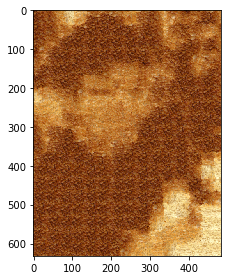

In [8]:
textDir = 'data/textures/';
imgDir = 'data/images/'
outDir = 'results_transfer/';

patchSize = 40
overlapErr = 7
alpha = 0.3

imageFile = 'keane.jpg'
texture = 'toast.png'

fileName = texture
texture = io.imread(textDir + fileName)
image = io.imread(imgDir + imageFile)
    
output = transfer(texture, image, patchSize, overlapErr, alpha)
save_image(output, outDir + fileName.split('.')[0] + "_" + imageFile.split('.')[0] + ".jpg")